In [1]:
import surprise
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from surprise import SVDpp, Reader, Dataset
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv('data_movies.csv')
df.head()

,UserID,Cr1,Cr2,Cr3,Cr4,Overall rating,MovieID,Frequency
0,1.0,6.0,6.0,8.0,12.0,8.0,2.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,9.0,11.0,10.0,9.0,10.0,26.0,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,6.0,10.0,9.0,8.0,7.0,61.0,3.0


In [3]:
df = df.dropna()

In [4]:
df_=df[['UserID','MovieID','Cr1','Cr2','Cr3','Cr4','Overall rating']]
df_.head()

,UserID,MovieID,Cr1,Cr2,Cr3,Cr4,Overall rating
0,1.0,2.0,6.0,6.0,8.0,12.0,8.0
2,1.0,26.0,9.0,11.0,10.0,9.0,10.0
4,1.0,61.0,6.0,10.0,9.0,8.0,7.0
6,1.0,86.0,6.0,6.0,6.0,5.0,5.0
8,1.0,132.0,10.0,11.0,10.0,9.0,10.0


In [5]:
new_df=df_.groupby('MovieID').filter(lambda x:x['Overall rating'].count() >=50)
new_df.head()

,UserID,MovieID,Cr1,Cr2,Cr3,Cr4,Overall rating
0,1.0,2.0,6.0,6.0,8.0,12.0,8.0
2,1.0,26.0,9.0,11.0,10.0,9.0,10.0
4,1.0,61.0,6.0,10.0,9.0,8.0,7.0
10,1.0,163.0,11.0,12.0,12.0,12.0,12.0
12,1.0,180.0,9.0,13.0,11.0,13.0,11.0


In [6]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50589 entries, 0 to 124310
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UserID          50589 non-null  float64
 1   MovieID         50589 non-null  float64
 2   Cr1             50589 non-null  float64
 3   Cr2             50589 non-null  float64
 4   Cr3             50589 non-null  float64
 5   Cr4             50589 non-null  float64
 6   Overall rating  50589 non-null  float64
dtypes: float64(7)
memory usage: 3.1 MB


In [19]:
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.model_selection import cross_validate
import pandas as pd


def svdpp(df):
    # We'll extract each criterion rating and train a separate SVD++ model for each of them.
    data = df

    # Create a Surprise Reader and Dataset
    reader = Reader(rating_scale=(1, 13))
    data_surprise = Dataset.load_from_df(data[['UserID', 'MovieID', 'Overall rating']], reader)

    # Split the data into training and testing sets using Surprise's train_test_split
    trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_epochs': [10, 20, 30, 40],
        'lr_all': [0.0005, 0.002, 0.005, 0.008, 0.01, 0.05],
        'reg_all': [0.01, 0.02, 0.04, 0.06, 0.1, 0.2, 0.5]
    }

    #
    # Initialize GridSearchCV with the SVD++ algorithm and the parameter grid
    gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)

    # Fit the GridSearchCV to the training data
    gs.fit(data_surprise)

    # Get the best parameters and estimator from the grid search
    best_params = gs.best_params['rmse']
    best_estimator = gs.best_estimator['rmse']

    # Print the best parameters
    print(f'Best Parameters for svdpp: {best_params}')

    # Train the best estimator on the full training set
    best_estimator.fit(trainset)


    # Make predictions for the test set
    predictions_svdpp = best_estimator.test(testset)
      # Evaluate the model
    from surprise import accuracy
    accuracy.rmse(predictions_svdpp)
    # Create a DataFrame from predictions_svd
    predictions_df = pd.DataFrame(predictions_svdpp, columns=["UserID", "MovieID", "Overall rating", "Predicted_Rating", "Details"])
    
    return predictions_df


In [20]:
y_pred = svdpp(new_df)

Best Parameters for svdpp: {'n_epochs': 40, 'lr_all': 0.002, 'reg_all': 0.1}
RMSE: 2.7037


In [21]:
#y_pred=y_pred.rename(columns={'Est':'Predicted_Rating'})
y_pred = y_pred.drop('Details', axis =1)
y_pred.head()

,UserID,MovieID,Overall rating,Predicted_Rating
0,3638.0,301.0,11.0,12.158805
1,3742.0,534.0,11.0,7.759663
2,5112.0,423.0,12.0,10.962087
3,4587.0,273.0,13.0,10.487142
4,2288.0,544.0,13.0,11.046713


In [22]:
def get_top_n_recommendations(y_pred, n):
    user_ids = y_pred['UserID'].values
    
    predicted_ratings_df = y_pred
    
    # This will sort the predictions within each group, then take the top n for each group
    top_n_recommendations = predicted_ratings_df.groupby(['UserID']).apply(lambda x: x.nlargest(n, 'Predicted_Rating')).reset_index(drop=True)
    return top_n_recommendations
n = 10
top_n = get_top_n_recommendations(y_pred, n)
top_n.shape

(9802, 4)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, recall_score, precision_score, f1_score, auc, average_precision_score
from sklearn.metrics import roc_curve
import numpy as np

def evaluation_metrics(y_pred, n):
    # get Top N recommendation
    top_n = get_top_n_recommendations(y_pred, n)
    
    # Retrieve the predictd rating and the actual rating
    true_ratings = top_n['Overall rating'].values
    prediction_ratings = top_n['Predicted_Rating'].values

    # Convert ratings to binary (e.g., positive/negative) for classification metrics
    binary_true_ratings = (true_ratings > 9).astype(int)
    binary_predictions = (np.array(prediction_ratings) > 9).astype(int)

    # RMSE(Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(true_ratings, prediction_ratings))

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(true_ratings, prediction_ratings)

    # Recall
    recall = recall_score(binary_true_ratings, binary_predictions)

    # Precision
    precision = precision_score(binary_true_ratings, binary_predictions)


    # F1-score
    f1 = f1_score(binary_true_ratings, binary_predictions)


    prediction_ratings = np.array(prediction_ratings)
    # Create a mask for pairs where true_rating1 < true_rating2
    mask = true_ratings[:, np.newaxis] < true_ratings

    # Calculate FCP using vectorized operations
    concordant_pairs = np.sum(mask * (prediction_ratings[:, np.newaxis] < prediction_ratings))
    discordant_pairs = np.sum(mask * (prediction_ratings[:, np.newaxis] > prediction_ratings))

    # Calculate FCP
    fcp = concordant_pairs / (concordant_pairs + discordant_pairs)


    # MAP (Mean Average Precision)
    avg_precision = average_precision_score(binary_true_ratings, prediction_ratings)

    # AUC (Area Under the Curve)
    fpr, tpr, _ = roc_curve(binary_true_ratings, prediction_ratings)
    auc_score = auc(fpr, tpr)



    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F-Measure: {f1:.4f}')
    print(f'MAP: {avg_precision:.4f}')
    print(f"AUC: {auc_score: .4f}")
    print(f'FCP: {fcp: .4f}')
    #print(f'NDCG: {ndcg: .4f}')

    
    
n=20
y_pred = y_pred
evaluation_metrics(y_pred, n)

RMSE: 2.7047
MAE: 1.9988
Precision: 0.7990
Recall: 0.8755
F-Measure: 0.8355
MAP: 0.8883
AUC:  0.8313
FCP:  0.7478


### Top-10, 5-Fold
RMSE: 2.7035
MAE: 1.9945
Precision: 0.8008
Recall: 0.8810
F-Measure: 0.8390
MAP: 0.8904
AUC:  0.8303
FCP:  0.7459

### Top-20, 5-Fold
RMSE: 2.7047
MAE: 1.9988
Precision: 0.7990
Recall: 0.8755
F-Measure: 0.8355
MAP: 0.8883
AUC:  0.8313
FCP:  0.7478

### Top-10, 10 Fold
RMSE: 2.6952
MAE: 1.9962
Precision: 0.8022
Recall: 0.8825
F-Measure: 0.8405
MAP: 0.8896
AUC:  0.8297
FCP:  0.7471

### Top-20, 10 Fold
RMSE: 2.6969
MAE: 1.9996
Precision: 0.8007
Recall: 0.8767
F-Measure: 0.8370
MAP: 0.8877
AUC:  0.8311
FCP:  0.7492

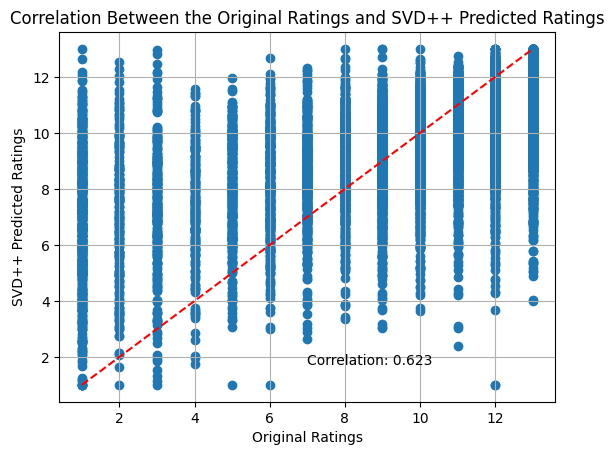

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

predicted_ratings = y_pred['Predicted_Rating']
original_ratings = y_pred['Overall rating']

# Compute the correlation Coefficient
corr = original_ratings.corr(predicted_ratings)
plt.annotate(f'Correlation: {corr:.3f}', xy=(0.5, 0.1), xycoords='axes fraction')

# Create a scatter plot
plt.scatter(original_ratings, predicted_ratings)
plt.title("Correlation Between the Original Ratings and SVD++ Predicted Ratings")
plt.xlabel("Original Ratings")
plt.ylabel("SVD++ Predicted Ratings")
plt.grid(True)

# You can add a diagonal line for reference (perfect correlation)
plt.plot([min(original_ratings), max(original_ratings)], [min(original_ratings), max(original_ratings)], color='red', linestyle='--')

# Show the plot
plt.show()